# Financial News - Preprocessing for word2vec

See notebook [lda_financial_news](../15_topic_modeling/07_financial_news/lda_financial_news.ipynb) for download instructions.

## Data

<div style='direction:rtl; font-family: "B Nazanin"; font-size: 20px;'> 
دستورالعمل دانلود داده‌ها در سلول زیر قرار داده شده است. 
توجه شود که به دلیل حجم بالای داده و زمان طولانی پردازش آن، صرفا از بخشی از داده برای انجام عملیات گفته شده استفاده کردیم
اما در صورت نیاز می‌توان از سیستمی با توان پردازشی بالا و استفاده از GPU به جای CPU در زمان مناسبی از کل داده‌ها استفاده کنیم.

The data is avaialble from [Kaggle](https://www.kaggle.com/jeet2016/us-financial-news-articles). 

Download and unzip into data directory in repository root folder, then rename the enclosing folder to `us-financial-news` and the subfolders so you get the following directory structure:
```
data
  |-us-financial-news
     |-2018_01
     |-2018_02
     |-2018_03
     |-2018_04
     |-2018_05
```

## Imports

In [1]:
using Pkg

In [2]:
using PyCall
using Conda

In [3]:
#Pkg.add("Glob")
#Pkg.add("TextAnalysis")
#Pkg.add("DataFrames")
#Pkg.add("Plots")
#Pkg.add("CSV")
#Pkg.add("Seaborn")
#Pkg.add("ScikitLearn")
#Pkg.add("Embeddings")
#Pkg.add("JSON")
#Pkg.add("StatsBase")
#Pkg.add("StringEncodings")

In [4]:
using Glob
using Pipe
using DataFrames
using TextAnalysis
using Plots
using CSV
using JSON
using StatsBase
using StringEncodings

### Settings

In [5]:
#Conda.pip_interop(true)

In [6]:
#Conda.pip("install", "https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.3.0/en_core_web_sm-3.3.0-py3-none-any.whl")
#Conda.pip("install", "https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.3.0/en_core_web_sm-3.3.0.tar.gz")

In [7]:
#Conda.add("spacy")
@pyimport spacy

In [8]:
function format_time(t)
    m = t ÷ 60
    s = t % 60
    h = m ÷ 60
    m = m % 60
    h = length("$h") == 2 ? h : "0$h"
    m = length("$m") == 2 ? m : "0$m"
    s = length("$s") == 2 ? s : "0$s"
    return "$h:$m:$s"
end

format_time (generic function with 1 method)

In [9]:
file = CSV.File(download("http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words"))
df = DataFrames.DataFrame(file)
rename!(df, ["stopwords"])
stop_words = Set(push!(df.stopwords, "a"))

Set{String15} with 319 elements:
  "cry"
  "whoever"
  "anything"
  "everywhere"
  "give"
  "during"
  "whose"
  "sometimes"
  "thick"
  "those"
  "rather"
  "and"
  "wherever"
  "these"
  "latterly"
  "least"
  "us"
  "either"
  "several"
  "they"
  "often"
  "whenever"
  "above"
  "eight"
  "such"
  ⋮ 

### Paths

In [10]:
fin_news_path = joinpath("..", "data", "us-financial-news")

"..\\data\\us-financial-news"

In [11]:
results_path = joinpath("results", "financial_news")
if !(isdir(results_path))
    mkpath(results_path)
end

In [12]:
article_path = joinpath(results_path, "articles.txt")
clean_article_path = joinpath(results_path, "articles_clean.txt")

"results\\financial_news\\articles_clean.txt"

## Load Data

In [13]:
section_titles = ["Press Releases - CNBC",
                  "Reuters: Company News",
                  "Reuters: World News",
                  "Reuters: Business News",
                  "Reuters: Financial Services and Real Estate",
                  "Top News and Analysis (pro)",
                  "Reuters: Top News",
                  "The Wall Street Journal &amp; Breaking News, Business, Financial and Economic News, World News and Video",
                  "Business &amp; Financial News, U.S &amp; International Breaking News | Reuters",
                  "Reuters: Money News", "Reuters: Technology News"]

11-element Vector{String}:
 "Press Releases - CNBC"
 "Reuters: Company News"
 "Reuters: World News"
 "Reuters: Business News"
 "Reuters: Financial Services and Real Estate"
 "Top News and Analysis (pro)"
 "Reuters: Top News"
 "The Wall Street Journal &amp; B" ⋯ 42 bytes ⋯ "omic News, World News and Video"
 "Business &amp; Financial News, U.S &amp; International Breaking News | Reuters"
 "Reuters: Money News"
 "Reuters: Technology News"

In [14]:
files = Glob.glob("../data/us-financial-news/**/*.json")

306242-element Vector{String}:
 "..\\data\\us-financial-news\\2018_01\\blogs_0000001.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000002.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000010.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000048.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000083.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000101.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000102.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000103.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000104.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000105.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000415.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000416.json"
 "..\\data\\us-financial-news\\2018_01\\blogs_0000417.json"
 ⋮
 "..\\data\\us-financial-news\\2018_05\\news_0063127.json"
 "..\\data\\us-financial-news\\2018_05\\news_0063128.json"
 "..\\data\\us-financial-news\\2018_05\\news_0063129.json"
 "..\\dat

In [15]:
articles = Any[]
counter = Dict()
for f ∈ files[1:10000]
    article = JSON.parsefile(f)
    if article["thread"]["section_title"] ∈ section_titles
        text = [String(s) for s ∈ split(lowercase(article["text"]))]
        addcounts!(counter, text)
        push!(articles, join([t for t ∈ text if !(t ∈ stop_words)], " "))
    end
end

In [16]:
open(article_path, "w") do file
    write(file, join(articles, "\n"))
end

10597227

## Clean Financial News Articles

In [17]:
open(article_path, "r") do file
    s = StringDecoder(file,"LATIN1", "UTF-8")
    articles = readlines(file)
end
length(articles)

5185

### Sentence Boundary Detection

In [18]:
function clean_doc(d)
    doc = Any[]
    for sent ∈ d.sents
        s = [lowercase(t.text) for t ∈ sent if !(t.is_digit || !(t.is_alpha) || t.is_punct || t.is_space)]
        if length(s) > 5 || length(sent) < 100
            push!(doc, join(s, " "))
        end
    end
    return doc
end

clean_doc (generic function with 1 method)

In [19]:
nlp = spacy.load("en_core_web_sm")

PyObject <spacy.lang.en.English object at 0x0000000070134C10>

In [20]:
clean_articles = Any[]
for article ∈ articles
    clean_articles = vcat(clean_articles, clean_doc(nlp(article)))
end

In [21]:
open(clean_article_path, "w") do file
    write(file, join(clean_articles, "\n"))
end

9501445

### Corpus Stats

In [22]:
length(clean_articles)

87024

In [23]:
vocab = Dict()
sent_length = Any[]
for sentence ∈ clean_articles
    tokens = split(lowercase(sentence))
    push!(sent_length, length(tokens))
    addcounts!(vocab, tokens)
end

In [24]:
length(sent_length)

87024

In [25]:
first(DataFrame(sent_length=sent_length), 10)

,sent_length
,Any
1,12
2,11
3,18
4,17
5,10
6,9
7,8
8,10
9,9


In [26]:
tokens = Any[]
counts = Any[]
for (token, count) ∈ vocab
    if !(lowercase(token) ∈ stop_words)
        push!(tokens, token)
        push!(counts, count)
    end
end

In [27]:
most_common = sort!(DataFrame(token=tokens, count=counts), :count, rev=true)

,token,count
,Any,Any
1,said,13165
2,company,8745
3,year,6498
4,percent,6450
5,reuters,5852
6,new,5761
7,president,3799
8,market,3585
9,million,3553


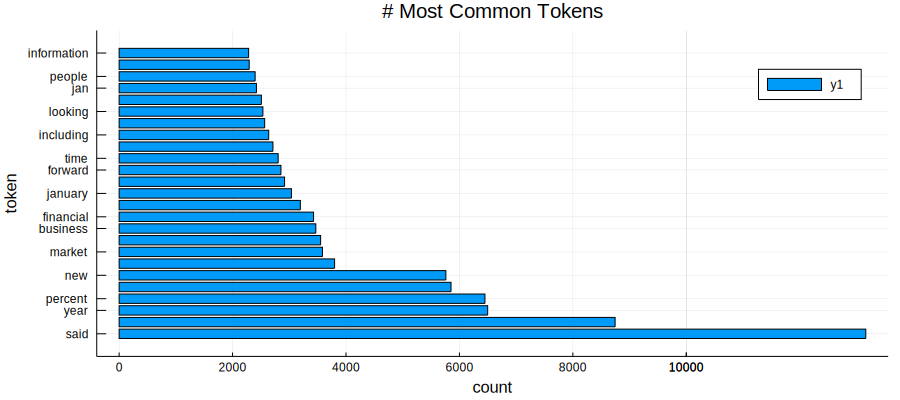

In [28]:
bar(first(most_common[:token], 25), first(most_common[:count], 25), orientation=:horizontal)
plot!(size=(900, 400))
ylabel!("token")
xlabel!("count")
Plots.title!("# Most Common Tokens")

### Inspect Result

In [29]:
clean_articles[1:3]

3-element Vector{Any}:
 "hours ago emerging markets soared percent todd gordon says rally wo stop"
 "big rally emerging markets tracked emerging market etf eem weak dollar"
 "given gordon sees inverse relat" ⋯ 65 bytes ⋯ "es currency continue help group"

## Create n-grams

In [30]:
max_length = 3

3

In [31]:
function get_clean_articles(clean_article_path)
    file = open(clean_article_path, "r")
    s = StringDecoder(file,"LATIN1", "UTF-8")
    articles = readlines(s)
    close(file)
    return articles
end

get_clean_articles (generic function with 1 method)

In [32]:
function get_ngram_articles(articles, n)
    sentences = Any[]
    ngram_counter = Dict()
    for article ∈ articles
        doc = StringDocument(article)
        doc_ngram = ngrams(doc, n)
        for (k, v) ∈ doc_ngram
            if k ∈ keys(ngram_counter)
                ngram_counter[k] += v
            else
                ngram_counter[k] = v
            end
        end
        sentence = join(keys(doc_ngram), " ") * "\n"
        push!(sentences, sentence)
    end
    return ngram_counter, sentences
end

get_ngram_articles (generic function with 1 method)

In [33]:
data_path = joinpath("data", "fin_news", "data")
if !(isdir(data_path))
    mkpath(data_path)
end

In [34]:
value_counts(df, col) = combine(groupby(df, col), nrow)

value_counts (generic function with 1 method)

In [35]:
n_grams_df = DataFrame()
start = time()
articles = get_clean_articles(clean_article_path)

for n ∈ 2 : max_length
    if n > 2
        articles = get_clean_articles(joinpath(results_path, "articles_$(n-1)_grams.txt"))
    end

    ngram_counter, sentences = get_ngram_articles(articles, n)

    s = DataFrame(length = [n for i ∈ 1:length(keys(ngram_counter))], 
                            phrase = [ngram_word for ngram_word ∈ keys(ngram_counter)], 
                            count = [ngram_count for ngram_count ∈ values(ngram_counter)])
    
    n_grams_df = vcat(n_grams_df, s)

    open(joinpath(results_path, "articles_$(n)_grams.txt"), "w") do file
        for sentence ∈ sentences
            write(file, sentence)
        end
    end

    open(joinpath(data_path, "articles_$(n)_grams.txt"), "w") do file
        for sentence ∈ sentences
            write(file, sentence)
        end
    end
end

n_grams_df = sort!(n_grams_df, :count, rev=true)
n_grams_df[!, "ngram"] = replace.(n_grams_df[:, "phrase"], " "=>"_")


println("Duration: $(format_time(floor(Int, (time() - start))))\n")
println("ngrams: $(size(n_grams_df)[1])\n")
println(value_counts(n_grams_df, :length))


Duration: 00:01:07

ngrams: 2282853

2×2 DataFrame
│ Row │ length │ nrow    │
│     │ Int64  │ Int64   │
├─────┼────────┼─────────┤
│ 1   │ 2      │ 590148  │
│ 2   │ 3      │ 1692705 │


In [36]:
n_grams_df

,length,phrase,count,ngram
,Int64,String,Int64,String
1,2,forward looking,2155,forward_looking
2,2,looking statements,1912,looking_statements
3,2,united states,1470,united_states
4,2,min read,1402,min_read
5,2,new york,1312,new_york
6,2,reuters staff,1255,reuters_staff
7,2,minutes ago,982,minutes_ago
8,2,updated minutes,980,updated_minutes
9,2,jan reuters,943,jan_reuters


In [37]:
@pipe n_grams_df |>
    groupby(_, :length) |>
    combine(_) do sdf
        sorted = sort(sdf, :count, rev=true)
        first(sorted, 10)
    end

,length,phrase,count,ngram
,Int64,String,Int64,String
1,2,forward looking,2155,forward_looking
2,2,looking statements,1912,looking_statements
3,2,united states,1470,united_states
4,2,min read,1402,min_read
5,2,new york,1312,new_york
6,2,reuters staff,1255,reuters_staff
7,2,minutes ago,982,minutes_ago
8,2,updated minutes,980,updated_minutes
9,2,jan reuters,943,jan_reuters
